## BASIC IDEA OF THE KERNEL

The data consists of a one dimensional time series x with 600 Million data points. 
At test time, we will see a time series of length 150'000 to predict the next earthquake.
The idea of this kernel is to randomly sample chunks of length 150'000 from x, derive some
features and use them to update weights of a recurrent neural net with 150'000 / 1000 = 150
time steps. 

Model overview :
1. LSTM Autoencoder to extract features
2. Feed these features and new input to prediction model
3. Prediction model - 1GRU layer followed by 2 Dense Layers
3. Number of features 36 - Max, min , standard deviation, mean
4. Data visulatization with 1% sampled data, and vanilla 1,500,000 input samples


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import statsmodels.api as sm

from scipy.stats import entropy


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


In [2]:

from tqdm import tqdm

# Fix seeds
from numpy.random import seed
seed(639)
from tensorflow import set_random_seed
set_random_seed(5944)

# Import
%time float_data = pd.read_csv("../input/train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values

CPU times: user 2min 10s, sys: 10.4 s, total: 2min 20s
Wall time: 2min 20s


In [3]:
np.shape(float_data)

(629145480, 2)

## Data Visualization

[12. -1.  7. ...  4.  4.  7.]


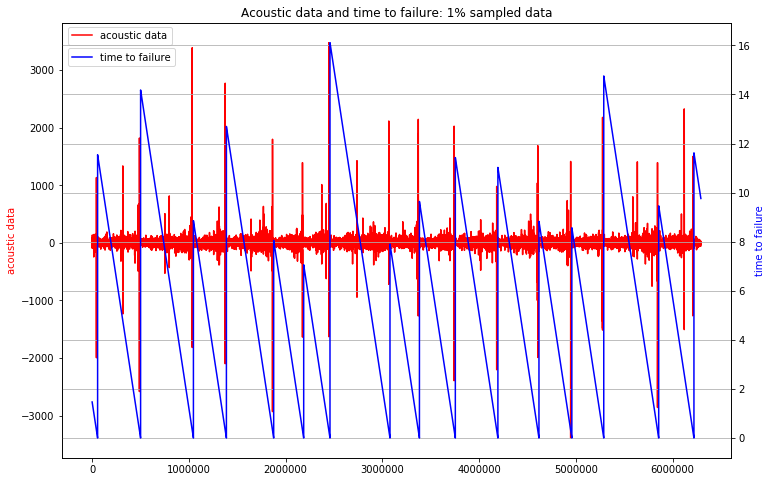

In [4]:
import matplotlib.pyplot as plt
train_ad_sample_df = float_data[:, 0]
train_ad_sample_df = train_ad_sample_df[: : 100]
print(train_ad_sample_df)
train_ttf_sample_df = float_data[:, 1]
train_ttf_sample_df = train_ttf_sample_df[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
#for i in range(1 , 1500000, 150000):
#    train_ad_sample_df = float_data[i : i + 150000, 0]
#    train_ttf_sample_df = float_data[i : i + 150000, 1]
#    plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df,  title = "Acoustic data and time to failure: First 150k data")
del train_ad_sample_df
del train_ttf_sample_df


Helper function for the data generator. Extracts mean, standard deviation, and quantiles per time step.
Can easily be extended. Expects a two dimensional array.

In [5]:

def extract_features(z):
     return np.c_[z.mean(axis=1), 
                  z.min(axis=1),
                  z.max(axis=1),
                  z.std(axis=1)]
    
def _extract_time_series(x, i, window, taille):
    """Function extracting the sub time series from a pandas Series. We use
    this function  because the pandas Series does not have same properties
    as numpy array"""
   
    # Need to differentiate the last case
    if i != taille:
        x_int = x[x.index[i-window]:x.index[i-1]]
    else:
        x_int = x[x.index[i-window]:]
        
    return x_int
    
def ts_autocorrelation(x, window):
    """Computes the time series autocorrelation for a rolling window"""
        
    # Initialize output
    res = pd.Series(data = None, index = x.index, name = 'autocorr')
    
    # Loop through the time series
    for i in range(window, len(x)  + 1):
        res[res.index[i-1]] = _extract_time_series(x, i, window, len(x)).autocorr() 

    return res

        
def ts_mean(x, window):
    """Computes the time series mean for a rolling window"""
    
    # Change name
    x.name = 'average'
    
    return x.rolling(window, min_periods=1).mean()

def ts_var(x, window):
    """Computes the time series variance for a rolling window"""
    
    # Change name
    x.name = 'variance'
    
    return x.rolling(window, min_periods=1).var()


def ts_entropy(x, window):
    """Computes the time series entropy for a rolling window"""
    
    # Initialize output
    res = pd.Series(data = None, index = x.index, name = 'entropy')
    
    # Loop through the time series
    for i in range(window, len(x) + 1):
        res[res.index[i-1]] = entropy(_extract_time_series(x, i, window, len(x)))
            
    return res

def ts_trend( x, window):
    """Computes the trend coefficient and the variance of the residuals of
    the time series versus the trend, for a rolling window"""
    
    # Initialize outputs
    res1 = pd.Series(data = None, index = x.index, name = 'trend')
    res2 = pd.Series(data = None, index = x.index, name = 'trend_p_value')
    res3 = pd.Series(data = None, index = x.index, name = 'residuals_variance')
    
    # Create the X, to compute the trend
    x_int = np.arange(window)
    x_int = sm.add_constant(x_int)

    # Loop through the time series
    for i in range(window, len(x)):
        
        # Extract the corresponding time series window
        y_int = _extract_time_series(x, i, window, len(x))
                    
        # Linear Model
        m = sm.OLS(y_int, x_int)
        results = m.fit()
        
        # Trend value and its p-value
        res1[res1.index[i-1]] = results.params['x1']
        res2[res2.index[i-1]] = results.pvalues['x1']
        
        # Strength of trend
        res3[res3.index[i-1]] = np.var(results.predict(x_int) - y_int)
        
    return res1, res2, res3

def ts_spike( x, window):
    """Computes the spike of a time series, for a rolling window"""

    # Initialize output
    res = pd.Series(data = None, index = x.index, name = 'spike')
    
    # Loop through the time series
    for i in range(window, len(x) + 1):
        
        # Extract the corresponding time series window and computes the spike
        x_int = _extract_time_series(x, i, window, len(x))
        res[res.index[i-1]] = function_spike(x_int, window)
        
    return res

def function_spike(x, window):
    """Computes the spike function for a time series"""
    
    # Computes the max and min spikes versus the average
    M, m = x.max() - x.mean(), x.min() - x.mean()
    
    # Return the biggest spike
    if np.abs(M) > np.abs(m):
        xtrm = M
    else:
        xtrm = m
    
    return xtrm

def ts_crossing_points( x, window):
    """Computes the number of times the mean is crossed by the time series 
    for a rolling window"""
    
    # Initialize output
    res = pd.Series(data = None, index = x.index, name = 'crossing_points')
    
    # Loop through time series
    for i in range(window, len(x)  + 1):
        
        # Extract the corresponding time series window and computes the crossing points
        x_int = _extract_time_series(x, i, window, len(x))
        res[res.index[i-1]] = function_crossing_points(x_int, window)
        
    return res
        
def function_crossing_points( x, window):
    """Computes the number of times the times series cross its mean"""
    
    # Reduce the mean
    x = np.sign(x - x.mean())
        
    # Number of times the mean is crossed
    x = x.diff().fillna(0)
    return np.abs(x).sum() / 2



For a given ending position "last_index", we split the last 150'000 values 
of "x" into 150 pieces of length 1000 each. So n_steps * step_length should equal 150'000.
From each piece, a set features are extracted. This results in a feature matrix 
of dimension (150 time steps x features).  

In [6]:

def create_X(x, last_index=None, n_steps=150, step_length=1000, window = 32):
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0
    
    # Reshaping and approximate standardization with mean 5 and std 3.
    temp = (x[(last_index - n_steps * step_length):last_index] - 5 ).reshape(n_steps, -1) / 3
    
    return temp
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations. 
    #return np.c_[extract_features(temp),
    #             extract_features(temp[:, -step_length // 5:]),
    #             extract_features(temp[:, -step_length // 10:]),
    #             extract_features(temp[:, -step_length // 20:]),
    #             extract_features(temp[:, -step_length // 25:]),
    #             extract_features(temp[:, -step_length // 40:]),
    #             extract_features(temp[:, -step_length // 50:]),
    #             extract_features(temp[:, -step_length // 100:])]


In [7]:
# Query "create_X" to figure out the number of features
window = 32
#n_features = create_X(float_data[0:150000, 0]).shape[1]
n_features = 1
print("Our RNN is based on %i features"% n_features)
        
batch_size = 32

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
second_earthquake = 50085877
print(float_data[second_earthquake, 1])
print(float_data[second_earthquake, 0])

Our RNN is based on 1 features
0.0006954822
8.0


## LSTM AutoEncoder
 LSTM Autoencoder to extract high level features
 Note that the x input is in a raw format [m,n] where m are voltages 
 and n are the features. The sequence length is given by timesteps,
 and some data manipulation needs to be made before inputing the data in
 the model.
        

In [8]:

def create_variable_for_model(x, timesteps = 150):
    """Transform the variables inputs into an appropriate format for the 
    second model. The x input needs to be already in a numpy format."""
    
    # Initialize output
    res = []
    
    # Create the output
    for idx in range(len(x) - timesteps):
        res.append(x[idx:idx+timesteps])
    
    return np.array(res)

In [9]:
from keras.models import Model, Sequential
from keras.layers import Dense, CuDNNGRU
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, LSTM, RepeatVector

timesteps = 1000
num_encoder_tokens = timesteps
latent_dim = 64
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_encoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_encoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


The generator endlessly selects "batch_size" ending positions of sub-time series. For each ending position,
the "time_to_failure" serves as target, while the features are created by the function "create_X".

In [10]:
def generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
     
    while True:
        # Pick indices of ending positions
        rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, step_length))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        yield [samples, samples], samples

# Initialize generators

In [11]:

#train_gen = generator(float_data, batch_size=batch_size) # Use this for better score
train_gen = generator(float_data, batch_size=batch_size, min_index=second_earthquake + 1)
valid_gen = generator(float_data, batch_size=batch_size, max_index=second_earthquake)

## Compile and Fit Autoencoder

In [12]:
#Callbacks
cb = [ModelCheckpoint("model.hdf5", save_best_only=True, period=3)]
# Model
model.summary()
model.compile(loss = 'mae', optimizer=adam(lr=0.0005))
#model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
#          batch_size=batch_size,
#          epochs=30,
#          validation_split=0.2)
history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=30,
                              verbose=2,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=200)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1000)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 1000)   0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 64), (None,  272640      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 64), ( 272640      input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

/opt/conda/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 4/30
 - 426s - loss: 1.1606 - val_loss: 1.1907
Epoch 5/30
 - 425s - loss: 1.1650 - val_loss: 1.1622
Epoch 6/30
 - 422s - loss: 1.1650 - val_loss: 1.1662
Epoch 7/30


/opt/conda/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


 - 428s - loss: 1.1591 - val_loss: 1.1767
Epoch 8/30
 - 425s - loss: 1.1660 - val_loss: 1.1938
Epoch 9/30
 - 425s - loss: 1.1644 - val_loss: 1.1988
Epoch 10/30
 - 426s - loss: 1.1598 - val_loss: 1.2077
Epoch 11/30
 - 427s - loss: 1.1628 - val_loss: 1.1872
Epoch 12/30
 - 423s - loss: 1.1605 - val_loss: 1.1798
Epoch 13/30
 - 424s - loss: 1.1658 - val_loss: 1.1733
Epoch 14/30
 - 426s - loss: 1.1643 - val_loss: 1.1997
Epoch 15/30
 - 425s - loss: 1.1617 - val_loss: 1.1923
Epoch 16/30
 - 425s - loss: 1.1661 - val_loss: 1.1736
Epoch 17/30
 - 425s - loss: 1.1612 - val_loss: 1.1758
Epoch 18/30
 - 423s - loss: 1.1593 - val_loss: 1.1765
Epoch 19/30
 - 425s - loss: 1.1621 - val_loss: 1.1812
Epoch 20/30
 - 424s - loss: 1.1602 - val_loss: 1.1841
Epoch 21/30
 - 424s - loss: 1.1665 - val_loss: 1.1838
Epoch 22/30
 - 426s - loss: 1.1572 - val_loss: 1.1941
Epoch 23/30
 - 421s - loss: 1.1585 - val_loss: 1.1874
Epoch 24/30
 - 421s - loss: 1.1622 - val_loss: 1.1873
Epoch 25/30
 - 422s - loss: 1.1618 - val_l

# Visualize accuracies of autoencoder

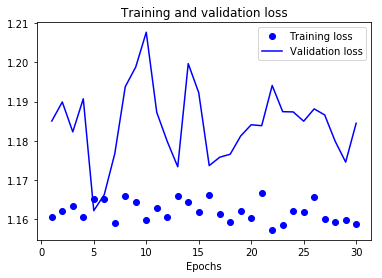

In [13]:
import matplotlib.pyplot as plt

def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None

perf_plot(history)

# Define prediction model

In [14]:
pred_model = Sequential()
pred_model.add(CuDNNGRU(48, input_shape=(None, n_features)))
pred_model.add(Dense(10, activation='relu'))
pred_model.add(Dense(1))

pred_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, 48)                7344      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                490       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 7,845
Trainable params: 7,845
Non-trainable params: 0
_________________________________________________________________



# Compile and fit model

In [15]:


pred_model.compile(optimizer=adam(lr=0.0005), loss="mae")

pred_history = pred_model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=30,
                              verbose=2,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=200)


Epoch 1/30


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 2 arrays: [array([[[ 0.33333334,  0.        ,  1.33333337, ...,  0.        ,
          0.        , -0.33333334],
        [ 0.33333334,  0.        ,  0.        , ..., -2.66666675,
         -2.33333325, -0.333333...


# Visualize accuracies

In [16]:
perf_plot(pred_history)

NameError: name 'pred_history' is not defined


# Load submission file

In [17]:

submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    submission.time_to_failure[i] = model.predict(np.expand_dims(create_X(x), 0))

submission.head()

# Save
submission.to_csv('submission.csv')

  0%|          | 0/2624 [00:00<?, ?it/s]


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[[-0.33333333, -1.66666667, -2.33333333, ..., -5.33333333,
         -6.66666667, -6.66666667],
        [-6.        , -3.        ,  1.        , ..., -2.66666667,
         -3.66666667, -2.333333...

### Changes to existing model derived from RNN Starter Kernel by Mayer
1. Increased number of features
2. Separate sampling of training and validation set
3. Added data visulation code
4. Added more features, inspired by Uber model

## References
1.  https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction
2.  https://www.kaggle.com/mayer79/rnn-starter-for-huge-time-series/
3. https://eng.uber.com/neural-networks/?fbclid=IwAR3cES3YhM8bW_OxEl6bla0zYpnQZ3Ixp30r0_V3XclfwLQ4_HK1osXNY9A
